<a href="https://colab.research.google.com/github/SamanvayMS/FIN-554-Algo-trading-finalproject/blob/main/VWAP_hypothesis_tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install yfinance

In [ ]:
pip install update pandas_datareader

In [92]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [93]:
yf.pdr_override()

In [94]:
start='2000-01-01'
end='2010-01-01'
df = yf.download('SPY',start,end)

[*********************100%***********************]  1 of 1 completed


In [95]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [96]:
def data_prep_VWAP(symbol,lookback,start,end):
  # Calculate the cumulative sum of price times volume
  df = yf.download(symbol,start,end)
  df['PV'] = df['Close'] * df['Volume']
  df['CumulativePV'] = df['PV'].rolling(lookback).sum()

  # Calculate the cumulative sum of volume
  df['CumulativeVolume'] = df['Volume'].rolling(lookback).sum()

  # Calculate the rolling VWAP
  df['RollingVWAP'] = df['CumulativePV'] / df['CumulativeVolume']
  df['signal']=np.where(df['Open']>df['RollingVWAP'].shift(1),1,0)
  df['returns']=(df['Close']-df['Open'])/df['Open']
  df['shifted_returns']=df['returns'].shift(-1)
  df['direction'] = [1 if x>0 else 0 for x in df['returns']]
  df=df.dropna(axis=0)
  return df

In [97]:
# here we look at stcoks from all the sectors of the market
sectors = ['Tech','Healthcare','Financial','Consumer_D','Consumer_S','Industrial','Energy','Utility','Market_ETF']
Tech_stocks=['AAPL','MSFT','NVDA','ADBE','CRM','GOOGL','AMZN','IBM','INTC','CSCO']
Healthcare_stocks=['JNJ','PFE','MRK','GILD','AMGN','BMY','LLY','REGN','UNH']
Financial_stocks=["JPM", "BAC", "WFC", "C", "GS", "MS", "V", "MA", "AXP", "SCHW"]
Consumer_D_stocks = ["HD", "MCD", "NKE", "SBUX", "DIS", "CMCSA", "LOW", "GM", "F", "BKNG"] # Consumer discretionary
Consumer_S_stocks= ["PG", "KO", "PEP", "WMT", "CL", "KMB", "CLX", "MDLZ", "EL"] #Consumer Staples
Industrial_stocks = ["BA", "GE", "MMM", "HON", "CAT", "RTX", "LMT", "GD", "UNP", "FDX"]
Energy_stocks = ["XOM", "CVX", "BP", "COP", "EOG", "OXY", "SLB", "KMI", "WMB"]
Utility_stocks = ["NEE", "DUK", "D", "SO", "EXC", "AEP", "SRE", "XEL", "WEC", "AWK"]
Market_ETF_stocks = ['SPY','QQQ']

### Asset selection for tests
Selected a basket of stocks from each sector for running and analysing the stocks and their sector wise dependence.
pros- can identify the sector wise dependence of stocks on indicators 
cons - 
survivorship bias as some stocks might delisted or just added 
overfitting bias as we are cherry picking stocks based on p value 


In [98]:
lookbacks=[9,20,50,100,200]

In [99]:
start='2000-01-01'
end='2015-01-01'

# Hypothesis Tests 


chi_squared test

In [100]:
from scipy.stats import chi2_contingency

H0 :- null hypothesis assumes no significant relationship between opening price and the previous rolling VWAP value

H1 :- significant relationship with the previous VWAP value bullish when above VWAP and bearish when below VWAP

In [101]:
def chi_2(Symbol,lookback,start,end,print_results=False):
  df = data_prep_VWAP(Symbol,lookback,start=start,end=end)
  observed=pd.crosstab(df['direction'],df['signal'])
  result = chi2_contingency(observed)
  if print_results:
    print(f"p value for {Symbol} is {result[1]}")
    if result[1]>0.01:
      print("null hypothesis cannot be rejected")
    else:
      print("null hypothesis is rejected")
  return result[1]

In [ ]:
chi_2_hypothesis_rejected=dict.fromkeys(sectors)
for sector in sectors:
  chi_2_hypothesis_rejected[sector]={}
  for stock in eval(sector+'_stocks'):
    chi_2_hypothesis_rejected[sector][stock]={}
    for lookback in lookbacks:
      p_value = chi_2(stock,lookback,start,end)
      if p_value<0.01:
        chi_2_hypothesis_rejected[sector][stock][lookback]=p_value


The stocks from each sector and the p values for the lookback period that was significant


In [103]:
chi_2_hypothesis_rejected

{'Tech': {'AAPL': {},
  'MSFT': {},
  'NVDA': {},
  'ADBE': {},
  'CRM': {},
  'GOOGL': {},
  'AMZN': {},
  'IBM': {20: 0.00022509312052244968, 50: 0.003404876069126242},
  'INTC': {20: 0.00195397880491183},
  'CSCO': {}},
 'Healthcare': {'JNJ': {},
  'PFE': {},
  'MRK': {},
  'GILD': {9: 0.009967699673768692},
  'AMGN': {9: 0.007729930807287963},
  'BMY': {},
  'LLY': {},
  'REGN': {},
  'UNH': {}},
 'Financial': {'JPM': {},
  'BAC': {50: 0.0004545738831357769,
   100: 0.0006559967461908341,
   200: 0.000354632984565625},
  'WFC': {9: 1.1413091044536635e-05, 20: 0.0002469740678344058},
  'C': {},
  'GS': {},
  'MS': {},
  'V': {},
  'MA': {},
  'AXP': {},
  'SCHW': {}},
 'Consumer_D': {'HD': {},
  'MCD': {},
  'NKE': {},
  'SBUX': {9: 0.0031921507465243015},
  'DIS': {},
  'CMCSA': {},
  'LOW': {},
  'GM': {},
  'F': {},
  'BKNG': {100: 0.0078052955394651725, 200: 0.00534061471338179}},
 'Consumer_S': {'PG': {},
  'KO': {200: 0.0019015133954092792},
  'PEP': {},
  'WMT': {},
  'CL': {

Looking at this we dont see too many stocks having clear relationship and the relationship is only visible in certain assets so this hypothesis can be rejected on the whole

wilcox rank test

In [104]:
from scipy.stats import ranksums
from scipy.stats import shapiro
from scipy.stats import ttest_ind

H0:-There is no significant relationship between the returns and the price's position relative to the VWAP.

H1:-The returns are significantly positive when the price is above the VWAP and significantly negative when the price is below the VWAP.

In [105]:
def tests(Symbol,lookback,start,end,print_results=False):
  df = data_prep_VWAP(Symbol,lookback,start=start,end=end)
  above_vwap = df[df['Open'] > df['RollingVWAP'].shift(1)]['returns']
  below_vwap = df[df['Open'] < df['RollingVWAP'].shift(1)]['returns']

  #plt.hist(above_vwap,bins=30,color="green",alpha=0.5)
  #plt.hist(below_vwap,bins=30,color="red",alpha=0.5)
  #plt.show()
  _, p_value1 = shapiro(above_vwap)
  _, p_value2 = shapiro(below_vwap)
  if p_value1 > 0.01 and p_value2 > 0.01:
    if print_results:
      print("returns are normally distributed")
      print("we can run a t-test")
    stat, p_value = ttest_ind(above_vwap, below_vwap, equal_var=True)
  else:
    if print_results:
      print("returns are not normally distributed")
      print("we can run a Wilcox Rank Sum test")    
    stat, p_value = ranksums(above_vwap, below_vwap)
  if print_results:
    print(f"p value for {Symbol} is {p_value}")
    if p_value>0.01:
      print("null hypothesis cannot be rejected")
    else:
      print("null hypothesis is rejected")
  return p_value

In [ ]:
WRT_hypothesis_rejected=dict.fromkeys(sectors)
for sector in sectors:
  WRT_hypothesis_rejected[sector]={}
  for stock in eval(sector+'_stocks'):
    WRT_hypothesis_rejected[sector][stock]={}
    for lookback in lookbacks:
      p_value = tests(stock,lookback,start,end)
      if p_value<0.01:
        WRT_hypothesis_rejected[sector][stock][lookback]=p_value

In [107]:
WRT_hypothesis_rejected

{'Tech': {'AAPL': {},
  'MSFT': {},
  'NVDA': {},
  'ADBE': {},
  'CRM': {},
  'GOOGL': {},
  'AMZN': {},
  'IBM': {20: 0.000627479671296681, 50: 0.001604488958014522},
  'INTC': {20: 0.0005059508507632124},
  'CSCO': {}},
 'Healthcare': {'JNJ': {},
  'PFE': {9: 0.005513933052505112},
  'MRK': {},
  'GILD': {9: 0.0041164552045779975},
  'AMGN': {9: 0.0011220472487111985},
  'BMY': {},
  'LLY': {},
  'REGN': {},
  'UNH': {}},
 'Financial': {'JPM': {},
  'BAC': {50: 0.00048498939807548643,
   100: 0.0016343801666512479,
   200: 0.0023914319763511317},
  'WFC': {9: 3.5535242307535772e-06, 20: 0.00018701641559694396},
  'C': {50: 0.0018418161026729648},
  'GS': {50: 0.009359279135939147},
  'MS': {},
  'V': {},
  'MA': {},
  'AXP': {},
  'SCHW': {}},
 'Consumer_D': {'HD': {},
  'MCD': {},
  'NKE': {},
  'SBUX': {9: 0.0010403601726963478},
  'DIS': {},
  'CMCSA': {},
  'LOW': {},
  'GM': {},
  'F': {50: 0.0002775309973352924,
   100: 0.00017668389625593537,
   200: 0.007896240391609532},
  

Looking at this we dont see too many stocks having clear relationship and the relationship is only visible in certain assets such as 'F', 'BP', 'BKNG' so this hypothesis can be rejected on the whole

# Taking moving averages


In [108]:
def data_prep_MA(symbol,lookback,start,end,smoothing_choice="s"):
  # Calculate the cumulative sum of price times volume
  df = yf.download(symbol,start,end)
  # Calculate the rolling MAs
  if smoothing_choice=='s':
    df['SMA']=df['Close'].rolling(window=lookback).mean()
  elif smoothing_choice=='e':
    df['EMA']=df['Close'].ewm(span=lookback, adjust=False).mean()
  df['returns']=(df['Close']-df['Open'])/df['Open']
  df=df.dropna(axis=0)
  return df

In [109]:
data_prep_MA('AAPL',lookback,start,end,'s')

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,SMA,returns
Date,,,,,,,,
2000-01-03,0.936384,1.004464,0.907924,0.999442,0.850644,535796800,NaN,0.067342
2000-01-04,0.966518,0.987723,0.903460,0.915179,0.778926,512377600,NaN,-0.053117
2000-01-05,0.926339,0.987165,0.919643,0.928571,0.790324,778321600,NaN,0.002410
2000-01-06,0.947545,0.955357,0.848214,0.848214,0.721931,767972800,NaN,-0.104830
2000-01-07,0.861607,0.901786,0.852679,0.888393,0.756127,460734400,NaN,0.031088
...,...,...,...,...,...,...,...,...
2014-12-24,28.145000,28.177500,28.002501,28.002501,25.167875,57918400,23.937804,-0.005063
2014-12-26,28.025000,28.629999,28.002501,28.497499,25.612764,134884000,23.985532,0.016860
2014-12-29,28.447500,28.692499,28.424999,28.477501,25.594790,110395600,24.034225,0.001055


In [110]:
def tests_MA(symbol,lookback,start,end,smoothing_choice,print_results=False,plot_dist=False):
  if smoothing_choice=='s':
    column='SMA'
  elif smoothing_choice=='e':
    column='EMA'
  else:
    print("invalid MA choice")
  df = data_prep_MA(symbol,lookback,start,end,smoothing_choice)
  above_ma = df[df['Open'] > df[column].shift(1)]['returns']
  below_ma = df[df['Open'] < df[column].shift(1)]['returns']
  if plot_dist:
    plt.hist(above_ma,bins=30,color="green",alpha=0.5)
    plt.hist(below_ma,bins=30,color="red",alpha=0.5)
    plt.show()
  
  _, p_value1 = shapiro(above_ma)
  _, p_value2 = shapiro(below_ma)
  if p_value1 > 0.01 and p_value2 > 0.01:
    if print_results:
      print("returns are normally distributed")
      print("we can run a t-test")
    stat, p_value = ttest_ind(above_ma, below_ma, equal_var=True)
  else:
    if print_results:
      print("returns are not normally distributed")
      print("we can run a Wilcox Rank Sum test")    
    stat, p_value = ranksums(above_ma, below_ma)
  if print_results:
    print(f"p value for {symbol} is {p_value}")
    if p_value>0.01:
      print("null hypothesis cannot be rejected")
    else:
      print("null hypothesis is rejected")
  return p_value

In [ ]:
EMA_hypothesis_rejected=dict.fromkeys(sectors)
for sector in sectors:
  EMA_hypothesis_rejected[sector]={}
  for stock in eval(sector+'_stocks'):
    EMA_hypothesis_rejected[sector][stock]={}
    for lookback in lookbacks:
      EMA_hypothesis_rejected[sector][stock][lookback]={}
      for ma_type in ['s','e']:
        p_value = tests(stock,lookback,start,end)
        if p_value<0.01:
          EMA_hypothesis_rejected[sector][stock][lookback][ma_type]=p_value

# Strategy Hypothesis

Use one tailed paired t-test for confirming this hypothesis

Instead of checking for daily returns we are going to check for cummulative returns.
we can do this by testing the strategy compared to that of a benchmark strategy sucha s a buy and hold. 
we test the hypothesis that the cummulative returns generated by the strategy are not different from that generated by the Buy and hold strategy 

# VWAP Hypothesis

### Indicators
Volume weighted moving average price - with different lookbacks 

### signals
*   signal(1) - close crossing above VWAP
*   signal(2) - close crossing below VWAP

### rules
*   long entry - close crossing above VWAP signal(1) - enter at next days open
*   long exit - close crossing below VWAP signal(2) - exit at next days open
*   short entry - close crossing below VWAP signal(2) - enter at next days open
*   short exit - close crossing above VWAP signal(1) - exit at next days open

In [112]:
def data_prep_VWAP2(symbol,lookback,start,end):
  # Calculate the cumulative sum of price times volume
  df = yf.download(symbol,start,end)
  df['PV'] = df['Close'] * df['Volume']
  df['CumulativePV'] = df['PV'].rolling(lookback).sum()

  # Calculate the cumulative sum of volume
  df['CumulativeVolume'] = df['Volume'].rolling(lookback).sum()

  # Calculate the rolling VWAP
  df['RollingVWAP'] = df['CumulativePV'] / df['CumulativeVolume']
  df['returns']=(df['Close']-df['Close'].shift(1))/df['Close'].shift(1)
  df["day's return"]=(df['Close']-df['Open'])/df['Open']
  df['overnight_return']=(df['Open']-df['Close'].shift(1))/df['Close'].shift(1)
  df=df.dropna(axis=0)
  return df

In [113]:
data_prep_VWAP2('AAPL',22,start,end)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,PV,CumulativePV,CumulativeVolume,RollingVWAP,returns,day's return
Date,,,,,,,,,,,,
2000-01-03,0.936384,1.004464,0.907924,0.999442,0.850643,535796800,5.354978e+08,NaN,NaN,NaN,NaN,0.067342
2000-01-04,0.966518,0.987723,0.903460,0.915179,0.778926,512377600,4.689172e+08,NaN,NaN,NaN,-0.084310,-0.053117
2000-01-05,0.926339,0.987165,0.919643,0.928571,0.790324,778321600,7.227269e+08,NaN,NaN,NaN,0.014633,0.002410
2000-01-06,0.947545,0.955357,0.848214,0.848214,0.721930,767972800,6.514053e+08,NaN,NaN,NaN,-0.086538,-0.104830
2000-01-07,0.861607,0.901786,0.852679,0.888393,0.756128,460734400,4.093132e+08,NaN,NaN,NaN,0.047369,0.031088
...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-24,28.145000,28.177500,28.002501,28.002501,25.167883,57918400,1.621860e+09,1.271327e+11,4.491455e+09,28.305468,-0.004709,-0.005063
2014-12-26,28.025000,28.629999,28.002501,28.497499,25.612761,134884000,3.843857e+09,1.253475e+11,4.436536e+09,28.253464,0.017677,0.016860
2014-12-29,28.447500,28.692499,28.424999,28.477501,25.594790,110395600,3.143791e+09,1.203957e+11,4.271570e+09,28.185344,-0.000702,0.001055


Trade Entry :- we wait for close to cross above VWAP and then enter at next days Open
Exit :- Once the Close is  below the VWAP we exit the position and take a short on the next days open (Ignoring Slippage)

In [114]:
def VWAP_crossover(symbol,lookback,start,end,print_trades=False):
  df = data_prep_VWAP2(symbol,lookback,start,end) # prepares the dataset
  df['strat_returns']=np.zeros(len(df)) # initialise the strategy column
  long_trade=False # sets long and short trade indicator to false 
  short_trade=False
  for date in df.index:
    if long_trade: 
      if just_entered:
        if print_trades:
          print('entered long trade',df.loc[date,"day's return"])
        df.loc[date,'strat_returns'] = df.loc[date,"day's return"]
        just_entered=False
      else:   
        if print_trades:
          print('in long trade',df.loc[date,'returns'])
        df.loc[date,'strat_returns'] = df.loc[date,'returns']
    elif short_trade:
      if just_entered:
        if print_trades:
          print('entered short trade',-df.loc[date,"day's return"])
        df.loc[date,'strat_returns'] = -df.loc[date,"day's return"]
        just_entered=False
      else:      
        if print_trades:
          print('in short trade',-df.loc[date,'returns'])
        df.loc[date,'strat_returns'] = -df.loc[date,'returns']
    else:
      df.loc[date,'strat_returns'] = 0
    if df.loc[date,'Close'] > df.loc[date,'RollingVWAP']:
      if long_trade==False:
        just_entered=True
      long_trade=True
      short_trade=False
    else:
      if short_trade==False:
        just_entered=True
      long_trade=False
      short_trade=True
  return df

In [115]:
ret=VWAP_crossover('D',100,start='2010-01-01',end='2011-01-01')
ret

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,PV,CumulativePV,CumulativeVolume,RollingVWAP,returns,day's return,strat_returns
Date,,,,,,,,,,,,,
2010-01-04,39.099998,39.419998,38.840000,38.959999,22.922113,2175500,8.475748e+07,NaN,NaN,NaN,NaN,-0.003581,0.000000
2010-01-05,38.860001,39.020000,38.080002,38.480000,22.639702,2802200,1.078287e+08,NaN,NaN,NaN,-0.012320,-0.009779,0.009779
2010-01-06,38.500000,38.730000,38.290001,38.520000,22.663244,2882500,1.110339e+08,NaN,NaN,NaN,0.001040,0.000519,-0.001040
2010-01-07,38.529999,38.599998,38.240002,38.580002,22.698544,1903400,7.343318e+07,NaN,NaN,NaN,0.001558,0.001298,-0.001558
2010-01-08,38.529999,38.619999,38.220001,38.560001,22.686769,1779000,6.859824e+07,NaN,NaN,NaN,-0.000518,0.000779,0.000518
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-12-27,42.849998,43.180000,42.750000,42.889999,26.390949,908000,3.894412e+07,1.269250e+10,292373700.0,43.411921,-0.001629,0.000934,0.001629
2010-12-28,42.840000,43.000000,42.680000,42.919998,26.409412,1458500,6.259882e+07,1.267347e+10,291957800.0,43.408577,0.000699,0.001867,-0.000699
2010-12-29,42.930000,43.070000,42.759998,42.939999,26.421715,1155300,4.960858e+07,1.261042e+10,290533200.0,43.404392,0.000466,0.000233,-0.000466


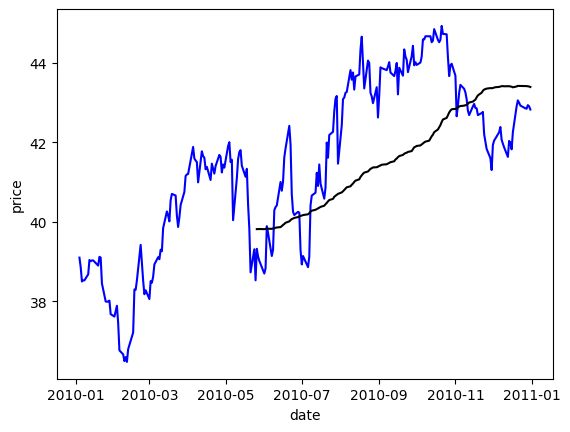

In [116]:
plt.plot(ret['Open'],c='blue')
plt.plot(ret['RollingVWAP'],c='black')
plt.xlabel('date')
plt.ylabel('price')
plt.show()

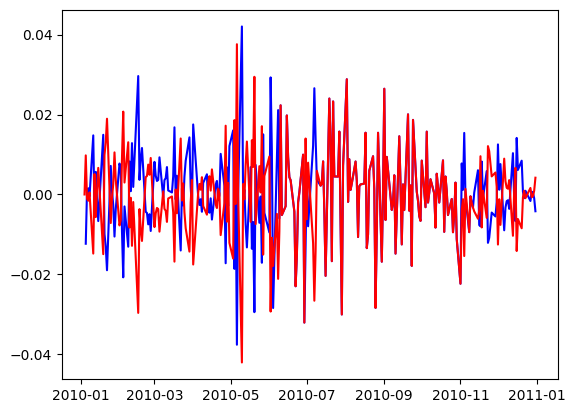

In [117]:
plt.plot(ret['returns'],c='blue')
plt.plot(ret['strat_returns'],c='red')
plt.show()

In [118]:
def cumret(returns):
  return (returns+1).cumprod()

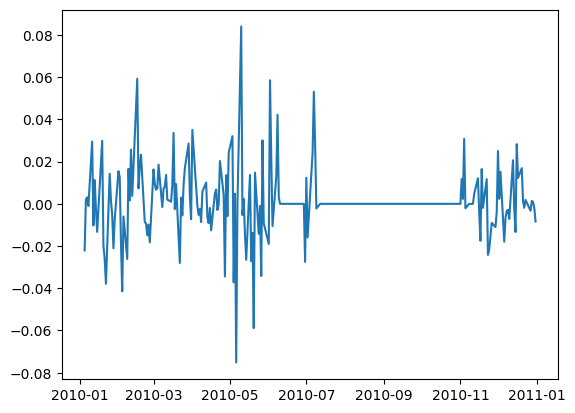

In [119]:
plt.plot(ret['returns']-ret['strat_returns'])

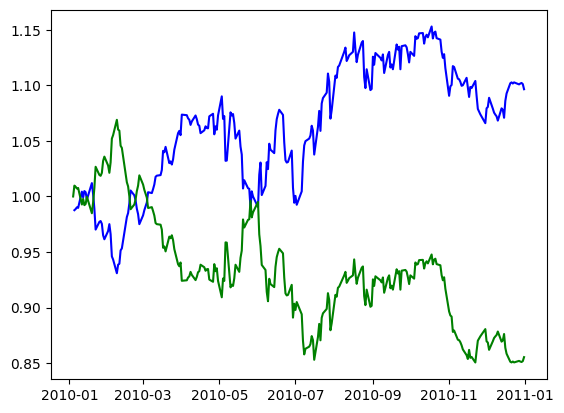

In [120]:
plt.plot(cumret(ret['returns']),c='blue')
plt.plot(cumret(ret['strat_returns']),c='green')
plt.show()

Below function gives us the drawdown and distribution plot for the returns of our bench mark and strategy on the asset

In [121]:
def statistics(df,get_plots=False):
  if isinstance(df, pd.DataFrame):
    """
    Calculates the drawdowns given a column of daily returns.
    Returns a pandas DataFrame with columns for daily returns,
    cumulative returns, and drawdowns.
    """
    # Calculate cumulative returns
    cum_returns = (1 + df.returns).cumprod()
    cum_returns_strat = (1 + df.strat_returns).cumprod()
    # Calculate the previous peaks
    previous_peaks = cum_returns.cummax()
    previous_peaks_strat = cum_returns_strat.cummax()

    # Calculate the drawdowns
    drawdowns = (cum_returns - previous_peaks) / previous_peaks
    drawdowns_strat = (cum_returns_strat - previous_peaks_strat) / previous_peaks_strat
    # Create a DataFrame with the results
    results = pd.DataFrame({'Cumulative Returns': cum_returns,
                            'Strategy Cumulative Returns': cum_returns_strat,
                            'Drawdowns': drawdowns,
                            'Strategy Drawdowns': drawdowns_strat})
    if get_plots==False:
      return results
    fig,axs = plt.subplots(3,figsize=(10,15))
    axs[0].plot(results.iloc[:,:2],label=results.columns[:2])
    axs[0].set_title('cummulative returns')
    axs[0].set_ylabel('Returns')
    axs[0].set_xlabel('date')
    axs[0].legend()
    axs[1].plot(results.iloc[:,2:],label=results.columns[2:])
    axs[1].set_title('drawdown')
    axs[1].set_ylabel('drawdown')
    axs[1].set_xlabel('date')
    axs[0].legend()
    axs[2].hist(df.returns,alpha=0.5,bins=30,label='benchmark')
    axs[2].hist(df.strat_returns,alpha=0.5,bins=30,label='strategy')
    axs[2].set_title('distribution of returns')
    axs[2].set_xlabel('returns')
    axs[2].set_ylabel('frequency')
    axs[2].legend()
    fig.show()
    return results
  else:
    print('invalid Datatype')
    return None



,Cumulative Returns,Strategy Cumulative Returns,Drawdowns,Strategy Drawdowns
Date,,,,
2010-01-04,NaN,1.000000,NaN,0.000000
2010-01-05,0.987680,1.009779,0.000000,0.000000
2010-01-06,0.988706,1.008729,0.000000,-0.001040
2010-01-07,0.990246,1.007158,0.000000,-0.002596
2010-01-08,0.989733,1.007680,-0.000518,-0.002079
...,...,...,...,...
2010-12-27,1.100873,0.852080,-0.045191,-0.202920
2010-12-28,1.101643,0.851484,-0.044524,-0.203477
2010-12-29,1.102156,0.851087,-0.044078,-0.203849


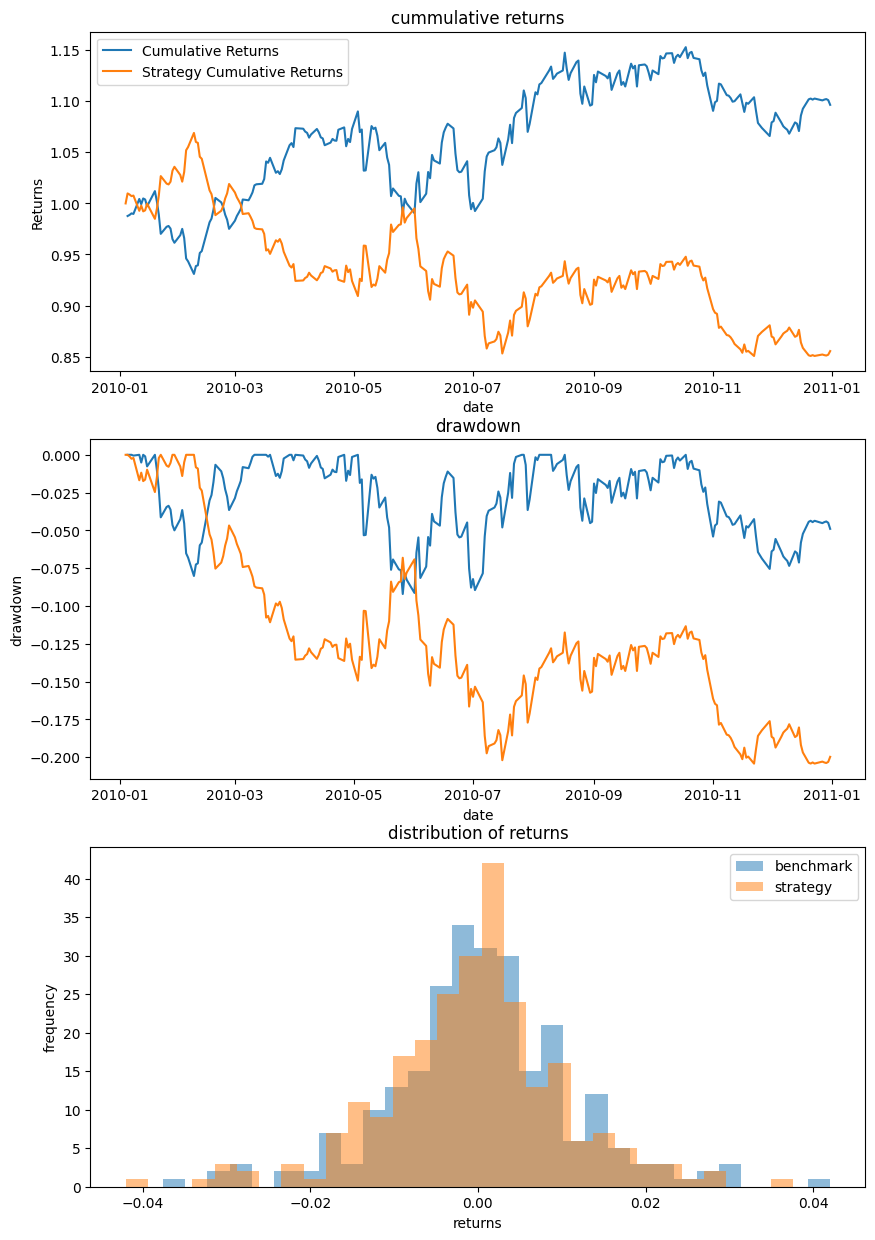

In [122]:
statistics(ret,True)

In [123]:
# strategy hypothesis tests

HO:- the returns of the strategy are not greater than that of the bench mark
H1:- the returns are greater

In [124]:
from scipy.stats import ttest_rel

In [125]:
def strat_1tailed_test(df,print_results=False):
  group1=df.returns
  group2=df.strat_returns
  t_stat, p_value = ttest_rel(group2, group1, alternative='greater')
  if print_results:
    print('mean_returns of benchmark = ',np.mean(group1))
    print('mean_returns of strategy = ',np.mean(group2))
    if p_value>0.01:
      print(f"null hypothesis cannot be rejected for this strategy")
    else:
      print(f"null hypothesis is rejected for this strategy")
  return p_value

In [126]:
strat_1tailed_test(ret)

nan

hypothesis can't be rejected

# VWAP Tests

In [ ]:
VWAP_strat_hypothesis_rejected=dict.fromkeys(sectors)
for sector in sectors:
  VWAP_strat_hypothesis_rejected[sector]={}
  for stock in eval(sector+'_stocks'):
    VWAP_strat_hypothesis_rejected[sector][stock]={}
    for lookback in lookbacks:
      df=VWAP_crossover(stock,lookback,start,end)
      p_value = strat_1tailed_test(df)
      if p_value<0.01:
        VWAP_strat_hypothesis_rejected[sector][stock][lookback]=p_value

In [128]:
VWAP_strat_hypothesis_rejected

{'Tech': {'AAPL': {},
  'MSFT': {},
  'NVDA': {},
  'ADBE': {},
  'CRM': {},
  'GOOGL': {},
  'AMZN': {},
  'IBM': {},
  'INTC': {},
  'CSCO': {}},
 'Healthcare': {'JNJ': {},
  'PFE': {},
  'MRK': {},
  'GILD': {},
  'AMGN': {},
  'BMY': {},
  'LLY': {},
  'REGN': {},
  'UNH': {}},
 'Financial': {'JPM': {},
  'BAC': {},
  'WFC': {},
  'C': {},
  'GS': {},
  'MS': {},
  'V': {},
  'MA': {},
  'AXP': {},
  'SCHW': {}},
 'Consumer_D': {'HD': {},
  'MCD': {},
  'NKE': {},
  'SBUX': {},
  'DIS': {},
  'CMCSA': {},
  'LOW': {},
  'GM': {},
  'F': {},
  'BKNG': {}},
 'Consumer_S': {'PG': {},
  'KO': {},
  'PEP': {},
  'WMT': {},
  'CL': {},
  'KMB': {},
  'CLX': {},
  'MDLZ': {},
  'EL': {}},
 'Industrial': {'BA': {},
  'GE': {},
  'MMM': {},
  'HON': {},
  'CAT': {},
  'RTX': {},
  'LMT': {},
  'GD': {},
  'UNP': {},
  'FDX': {}},
 'Energy': {'XOM': {},
  'CVX': {},
  'BP': {},
  'COP': {},
  'EOG': {},
  'OXY': {},
  'SLB': {},
  'KMI': {},
  'WMB': {}},
 'Utility': {'NEE': {},
  'DUK': {},

# MA strat

### Indicators
Simple/Exponential moving average price - with different lookbacks 

### signals
*   signal(1) - close crossing above MA
*   signal(2) - close crossing below MA

### rules
*   long entry - close crossing above MA signal(1) - enter at next days open
*   long exit - close crossing below MA signal(2) - exit at next days open
*   short entry - close crossing below MA signal(2) - enter at next days open
*   short exit - close crossing above MA signal(1) - exit at next days open

In [129]:
def data_prep_MA2(symbol,lookback,start,end,smoothing_choice="s"):
  # Calculate the cumulative sum of price times volume
  df = yf.download(symbol,start,end)
  # Calculate the rolling MAs
  if smoothing_choice=='s':
    df['SMA']=df['Close'].rolling(window=lookback).mean()
  elif smoothing_choice=='e':
    df['EMA']=df['Close'].ewm(span=lookback, adjust=False).mean()
  df['returns']=(df['Close']-df['Open'])/df['Open']
  df["day's return"]=(df['Close']-df['Open'])/df['Open']
  df=df.dropna(axis=0)
  return df 

In [130]:
def MA_crossover(symbol,lookback,start,end,smoothing_choice="s",print_trades=False):
  df = data_prep_MA2(symbol,lookback,start,end,smoothing_choice) # prepares the dataset
  df['strat_returns']=np.zeros(len(df)) # initialise the strategy column
  long_trade=False # sets long and short trade indicator to false 
  short_trade=False
  for date in df.index[200:]:
    if long_trade: 
      if just_entered:
        if print_trades:
          print('entered long trade',df.loc[date,"day's return"])
        df.loc[date,'strat_returns'] = df.loc[date,"day's return"]
        just_entered=False
      else:        
        if print_trades:
          print('in long trade',df.loc[date,'returns'])
        df.loc[date,'strat_returns'] = df.loc[date,'returns']
    elif short_trade:
      if just_entered:
        if print_trades:
          print('entered short trade',-df.loc[date,"day's return"])
        df.loc[date,'strat_returns'] = -df.loc[date,"day's return"]
        just_entered=False
      else:     
        if print_trades: 
          print('in short trade',-df.loc[date,'returns'])
        df.loc[date,'strat_returns'] = -df.loc[date,'returns']
    else:
      df.loc[date,'strat_returns'] = 0
    # check for ma type
    if smoothing_choice=='e':
      column = 'EMA'
    else:
      column = 'SMA'
    # strategy entry updates 
    if df.loc[date,'Close'] > df.loc[date,column]:
      if long_trade==False:
        just_entered=True
      long_trade=True
      short_trade=False
    else:
      if short_trade==False:
        just_entered=True
      long_trade=False
      short_trade=True
  return df

In [131]:
MA_crossover(symbol='spy',lookback=50,start=start,end=end,smoothing_choice="e")

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,EMA,returns,day's return,strat_returns
Date,,,,,,,,,,
2000-01-03,148.250000,148.250000,143.875000,145.437500,94.946442,8164300,145.437500,-0.018971,-0.018971,0.000000
2000-01-04,143.531250,144.062500,139.640625,139.750000,91.233452,8089800,145.214461,-0.026344,-0.026344,0.026344
2000-01-05,139.937500,141.531250,137.250000,140.000000,91.396683,12177900,145.009972,0.000447,0.000447,-0.000447
2000-01-06,139.625000,141.500000,137.750000,137.750000,89.927773,6227200,144.725267,-0.013429,-0.013429,0.013429
2000-01-07,140.312500,145.750000,140.062500,145.750000,95.150444,8066500,144.765453,0.038753,0.038753,-0.038753
...,...,...,...,...,...,...,...,...,...,...
2014-12-24,208.020004,208.339996,207.720001,207.770004,178.802643,42963400,202.954772,-0.001202,-0.001202,-0.001202
2014-12-26,208.309998,208.850006,208.250000,208.440002,179.379242,57326700,203.169879,0.000624,0.000624,0.000624
2014-12-29,208.220001,208.970001,208.139999,208.720001,179.620224,79643900,203.387531,0.002401,0.002401,0.002401


# MA Tests

In [ ]:
MA_strat_hypothesis_rejected=dict.fromkeys(sectors)
for sector in sectors:
  MA_strat_hypothesis_rejected[sector]={}
  for stock in eval(sector+'_stocks'):
    MA_strat_hypothesis_rejected[sector][stock]={}
    for ma_type in ['s','e']:
      MA_strat_hypothesis_rejected[sector][stock][ma_type]={}
      for lookback in lookbacks:
        df=MA_crossover(stock,lookback,start,end,ma_type)
        p_value = strat_1tailed_test(df)
      if p_value<0.01:
        MA_strat_hypothesis_rejected[sector][stock][ma_type][lookback]=p_value

In [133]:
MA_strat_hypothesis_rejected

{'Tech': {'AAPL': {9: {}, 20: {}, 50: {}, 100: {}, 200: {}},
  'MSFT': {9: {}, 20: {}, 50: {}, 100: {}, 200: {}},
  'NVDA': {9: {}, 20: {}, 50: {}, 100: {}, 200: {}},
  'ADBE': {9: {}, 20: {}, 50: {}, 100: {}, 200: {}},
  'CRM': {9: {}, 20: {}, 50: {}, 100: {}, 200: {}},
  'GOOGL': {9: {}, 20: {}, 50: {}, 100: {}, 200: {}},
  'AMZN': {9: {}, 20: {}, 50: {}, 100: {}, 200: {}},
  'IBM': {9: {}, 20: {}, 50: {}, 100: {}, 200: {}},
  'INTC': {9: {}, 20: {}, 50: {}, 100: {}, 200: {}},
  'CSCO': {9: {}, 20: {}, 50: {}, 100: {}, 200: {}}},
 'Healthcare': {'JNJ': {9: {}, 20: {}, 50: {}, 100: {}, 200: {}},
  'PFE': {9: {}, 20: {}, 50: {}, 100: {}, 200: {}},
  'MRK': {9: {}, 20: {}, 50: {}, 100: {}, 200: {}},
  'GILD': {9: {}, 20: {}, 50: {}, 100: {}, 200: {}},
  'AMGN': {9: {}, 20: {}, 50: {}, 100: {}, 200: {}},
  'BMY': {9: {}, 20: {}, 50: {}, 100: {}, 200: {}},
  'LLY': {9: {}, 20: {}, 50: {}, 100: {}, 200: {}},
  'REGN': {9: {}, 20: {}, 50: {}, 100: {}, 200: {}},
  'UNH': {9: {}, 20: {}, 50: 

# MA Crossover Strat

### Indicators
Multiple Moving Averages (simple and exponential) combinations of MAs and lookbacks. faster MAs have shorter lookbacks and slower MAs have longer lookbacks
### signals
*   signal(1) long entry - faster MAs are above slower MAs
*   signal(2) long exit - above order no longer holds good (faster MA crosses below slower MA
*   signal(3) short entry - faster MAs are below slower MAs
*   signal(4) short exit - above order no longer holds good (faster MA crosses above slower MA

### rules
*   long entry signal(1) - enter at next days open
*   long exit signal(2) - exit at next days open
*   short entry signal(3) - enter at next days open
*   short exit signal(4) - exit at next days open

In [161]:
def data_prep_MA_cross(symbol,lookback_list,start,end,smoothing_choice="s"):
  # Calculate the cumulative sum of price times volume
  df = yf.download(symbol,start,end)
  # Calculate the rolling MAs
  for lookback in lookback_list:
    if smoothing_choice=='s':
      df['SMA_'+str(lookback)]=df['Close'].rolling(window=lookback).mean()
    elif smoothing_choice=='e':
      df['EMA_'+str(lookback)]=df['Close'].ewm(span=lookback, adjust=False).mean()
  df['returns']=(df['Close']-df['Open'])/df['Open']
  df["day_return"]=(df['Close']-df['Open'])/df['Open']
  df=df.dropna(axis=0)
  return df 

In [162]:
aapl=data_prep_MA_cross('aapl',lookback_list=[50,100,200],start=start,end=end,smoothing_choice='s')

[*********************100%***********************]  1 of 1 completed


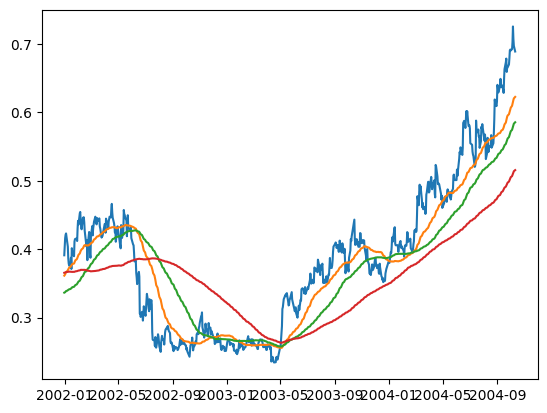

In [165]:
plt.plot(aapl[300:1000].loc[:,['Close','SMA_50','SMA_100','SMA_200']])

In [166]:
def long_trigger(df,columns,date):
  for i in range(len(columns)-1):
    if df.loc[date,columns[i]] >= df.loc[date,columns[i]]:
      return True

def short_trigger(df,columns,date):
  for i in range(len(columns)-1):
    if df.loc[date,columns[i]] >= df.loc[date,columns[i]]:
      return True

In [171]:
def Multiple_MA_crossover(symbol,lookback_list,start,end,smoothing_choice="s",print_trades=False):
  df = data_prep_MA_cross(symbol,lookback_list,start,end,smoothing_choice="s") # prepares the dataset
  df['strat_returns']=np.zeros(len(df)) # initialise the strategy column
  long_trade=False # sets long and short trade indicator to false 
  short_trade=False
  for date in df.index[200:]:
    if long_trade: 
      if just_entered:
        if print_trades:
          print('entered long trade',df.loc[date,"day_return"])
        df.loc[date,'strat_returns'] = df.loc[date,"day_return"]
        just_entered=False
      else:        
        if print_trades:
          print('in long trade',df.loc[date,'returns'])
        df.loc[date,'strat_returns'] = df.loc[date,'returns']
    elif short_trade:
      if just_entered:
        if print_trades:
          print('entered short trade',-df.loc[date,"day_return"])
        df.loc[date,'strat_returns'] = -df.loc[date,"day_return"]
        just_entered=False
      else:     
        if print_trades: 
          print('in short trade',-df.loc[date,'returns'])
        df.loc[date,'strat_returns'] = -df.loc[date,'returns']
    else:
      df.loc[date,'strat_returns'] = 0
    # check for ma type
    if smoothing_choice=='e':
      columns = [col for col in df.columns if col.startswith('EMA_')]
    else:
      columns = [col for col in df.columns if col.startswith('SMA_')]
    # strategy entry updates 
    if long_trigger(df,columns,date):
      if long_trade==False:
        just_entered=True
      long_trade=True
    else:
      long_trade=False
    if short_trigger(df,columns,date):
      if short_trade==False:
        just_entered=True
      short_trade=True
    else:
      short_trade=False
  return df

In [168]:
from itertools import combinations

def comb_generator(element_list,min,max):
  if max>len(element_list):
    max=len(element_list)
  lookback_comb=[]
  for length in range(min, max+1):
    lookback_comb += list(combinations(element_list, length))
  return lookback_comb
print(comb_generator(lookbacks,min=2,max=3))

[(9, 20), (9, 50), (9, 100), (9, 200), (20, 50), (20, 100), (20, 200), (50, 100), (50, 200), (100, 200), (9, 20, 50), (9, 20, 100), (9, 20, 200), (9, 50, 100), (9, 50, 200), (9, 100, 200), (20, 50, 100), (20, 50, 200), (20, 100, 200), (50, 100, 200)]


In [169]:
def index_generator(lookback_list):
  index=''
  for i in lookback_list:
    index += ('-'+ str(i))
  return index
print(index_generator([10,20,30]))

-10-20-30


In [ ]:
MA_crossover_strat_hypothesis_rejected=dict.fromkeys(sectors)
for sector in sectors:
  MA_crossover_strat_hypothesis_rejected[sector]={}
  for stock in eval(sector+'_stocks'):
    MA_crossover_strat_hypothesis_rejected[sector][stock]={}
    for ma_type in ['s','e']:
      MA_strat_hypothesis_rejected[sector][stock][ma_type]={}
      for lookback_list in comb_generator(lookbacks,min=2,max=3):
        df = Multiple_MA_crossover(stock,lookback_list,start,end,ma_type)
        p_value = strat_1tailed_test(df)
        if p_value<0.01:
          lookback_index = index_generator(lookback_list)
          MA_crossover_strat_hypothesis_rejected[sector][stock][ma_type][lookback_index]=p_value

In [173]:
MA_crossover_strat_hypothesis_rejected

{'Tech': {'AAPL': {'-9-20': {},
   '-9-50': {},
   '-9-100': {},
   '-9-200': {},
   '-20-50': {},
   '-20-100': {},
   '-20-200': {},
   '-50-100': {},
   '-50-200': {},
   '-100-200': {},
   '-9-20-50': {},
   '-9-20-100': {},
   '-9-20-200': {},
   '-9-50-100': {},
   '-9-50-200': {},
   '-9-100-200': {},
   '-20-50-100': {},
   '-20-50-200': {},
   '-20-100-200': {},
   '-50-100-200': {}},
  'MSFT': {'-9-20': {},
   '-9-50': {},
   '-9-100': {},
   '-9-200': {},
   '-20-50': {},
   '-20-100': {},
   '-20-200': {},
   '-50-100': {},
   '-50-200': {},
   '-100-200': {},
   '-9-20-50': {},
   '-9-20-100': {},
   '-9-20-200': {},
   '-9-50-100': {},
   '-9-50-200': {},
   '-9-100-200': {},
   '-20-50-100': {},
   '-20-50-200': {},
   '-20-100-200': {},
   '-50-100-200': {}},
  'NVDA': {'-9-20': {},
   '-9-50': {},
   '-9-100': {},
   '-9-200': {},
   '-20-50': {},
   '-20-100': {},
   '-20-200': {},
   '-50-100': {},
   '-50-200': {},
   '-100-200': {},
   '-9-20-50': {},
   '-9-20-100